<h4>Problem 4: [25 points]</h4>
You will extend Dquad to handle insertions (they will not handle deletions in this case). Please read and understand Section 1.1 in https://jeffe.cs.illinois.edu/teaching/datastructures/notes/01-statictodynamic.pdf. You should implement the insertion and the query of the quadtree based on this article.

Insert 6000 random points in the box [0, 1000] × [0, 1000].

Consider different values of ε = {0.05, 0.1, 0.15, 0.2, 0.25}. Run the ε-NN queries considering the following queries: q₀ = (500, 500), q₁ = (1000, 1000), q₃ = (30, 950), q₄ = (0, 1020). For each of these queries, create a figure that has the different values of ε on the x-axis, and the distance of q with the point returned by your data structure on the y-axis. Explain the results.

Next, fix ε = 0.1 and run 1000 random queries in the box [0, 1000] × [0, 1000]. Show the average query time and the average distance of the query with the point returned by you data structure. Next, fix ε = 0.1 and run 1000 random queries in the box [1000, 1500] × [1000, 1500]. Show the average query time and the average distance of the query with the point returned by you data structure.

Insert 2000 random points in the box [1000, 2000] × [1000, 2000]. Next, fix ε = 0.1 and run 1000 random queries in the box [1000, 2000] × [1000, 2000] × [1000, 2000] × [1000, 2000]. Show the average query time and the average distance of the query with the point returned by you data structure. Explain the results and compare with the random queries in the box [0, 1000] × [0, 1000] you computed just before you inserted the 20000 points.

In [2]:
#Question 4
import numpy as np
from queue import Queue
import matplotlib.pyplot as plt
import time



In [3]:
class QuadNode:
    def __init__(self, center, width):
        self.center = center
        self.width = width
        self.point = None
        self.children = None
        self.is_active = True

    def get_diameter(self):
        return 2 * self.width



In [4]:
class QuadTree:
    def __init__(self, points):
        self.points = points.copy()
        self.n = len(points)
        self.dim = points.shape[1]
        self.insertion_count = 0
        self.trees = []
        self.build_initial_tree()

    def build_initial_tree(self):
        if len(self.points) > 0:
            min_coords = np.min(self.points, axis=0)
            max_coords = np.max(self.points, axis=0)
            center = (min_coords + max_coords) / 2
            width = np.max(max_coords - min_coords) / 2
            tree = self.build_tree(self.points, center, width)
            self.trees.append(tree)

    def build_tree(self, points, center, width):
        node = QuadNode(center, width)
        if len(points) <= 1:
            if len(points) == 1:
                node.point = points[0]
            return node

        node.children = []
        for i in range(2 ** self.dim):
            child_center = center.copy()
            for d in range(self.dim):
                offset = width / 2 if (i & (1 << d)) else -width / 2
                child_center[d] += offset

            mask = np.ones(len(points), dtype=bool)
            for d in range(self.dim):
                if i & (1 << d):
                    mask &= points[:, d] >= center[d]
                else:
                    mask &= points[:, d] < center[d]

            child_points = points[mask]
            node.children.append(self.build_tree(child_points, child_center, width/2))

        for child in node.children:
            if child.point is not None:
                node.point = child.point
                break

        return node

    def insert(self, point):
        self.insertion_count += 1

        if self.insertion_count >= self.n:
            points = self.points.tolist()
            for tree in self.trees:
                if tree.point is not None:
                    points.append(tree.point)
            points.append(point)

            self.points = np.array(points)
            self.n = len(self.points)
            self.trees = []
            self.build_initial_tree()
            self.insertion_count = 0
        else:
            box_min = np.min(np.vstack([self.points, point]), axis=0)
            box_max = np.max(np.vstack([self.points, point]), axis=0)
            center = (box_min + box_max) / 2
            width = np.max(box_max - box_min) / 2

            node = QuadNode(center, width)
            node.point = point
            self.trees.append(node)

    def ann_search(self, query, epsilon):
        best_dist = float('inf')
        best_point = None

        for tree in self.trees:
            point, dist = self.search_tree(tree, query, epsilon)
            if point is not None and dist < best_dist:
                best_dist = dist
                best_point = point

        return best_point, best_dist

    def search_tree(self, root, query, epsilon):
        Q = Queue()
        Q.put(root)
        p_curr = root.point if root.point is not None else None
        r_curr = float('inf') if p_curr is None else np.linalg.norm(query - p_curr)

        while not Q.empty():
            u = Q.get()

            if u.point is not None:
                dist = np.linalg.norm(query - u.point)
                if dist < r_curr:
                    r_curr = dist
                    p_curr = u.point

            if u.children is not None:
                dist_to_cell = np.linalg.norm(query - u.center)
                if dist_to_cell - u.get_diameter() <= (2 - epsilon/2) * r_curr:
                    for child in u.children:
                        Q.put(child)

        return p_curr, r_curr



In [5]:
points = np.loadtxt('Pquad.txt', skiprows=1, delimiter=',')
tree = QuadTree(points)

new_points = np.random.uniform(0, 1000, size=(6000, 2))
insert_times = []

for point in new_points:
    start_time = time.time()
    tree.insert(point)
    insert_times.append(time.time() - start_time)

print(f"Average insertion time: {np.mean(insert_times)*1000:.2f} ms")

queries = {
    'q0': np.array([500, 500]),
    'q1': np.array([1000, 1000]),
    'q2': np.array([30, 950]),
    'q3': np.array([0, 1020])
}



Average insertion time: 0.83 ms



Results for q0:
ε=0.05: dist=2.26, point=[497.76 499.7 ]
ε=0.10: dist=2.26, point=[497.76 499.7 ]
ε=0.15: dist=2.26, point=[497.76 499.7 ]
ε=0.20: dist=2.26, point=[497.76 499.7 ]
ε=0.25: dist=2.26, point=[497.76 499.7 ]

Results for q1:
ε=0.05: dist=11.11, point=[996.26373948 989.53290717]
ε=0.10: dist=11.11, point=[996.26373948 989.53290717]
ε=0.15: dist=11.11, point=[996.26373948 989.53290717]
ε=0.20: dist=11.11, point=[996.26373948 989.53290717]
ε=0.25: dist=11.11, point=[996.26373948 989.53290717]

Results for q2:
ε=0.05: dist=5.19, point=[ 27.8880312 945.25528  ]
ε=0.10: dist=5.19, point=[ 27.8880312 945.25528  ]
ε=0.15: dist=5.19, point=[ 27.8880312 945.25528  ]
ε=0.20: dist=5.19, point=[ 27.8880312 945.25528  ]
ε=0.25: dist=5.19, point=[ 27.8880312 945.25528  ]

Results for q3:
ε=0.05: dist=31.46, point=[ 13.14 991.42]
ε=0.10: dist=31.46, point=[ 13.14 991.42]
ε=0.15: dist=31.46, point=[ 13.14 991.42]
ε=0.20: dist=31.46, point=[ 13.14 991.42]
ε=0.25: dist=31.46, point=[ 13.14 

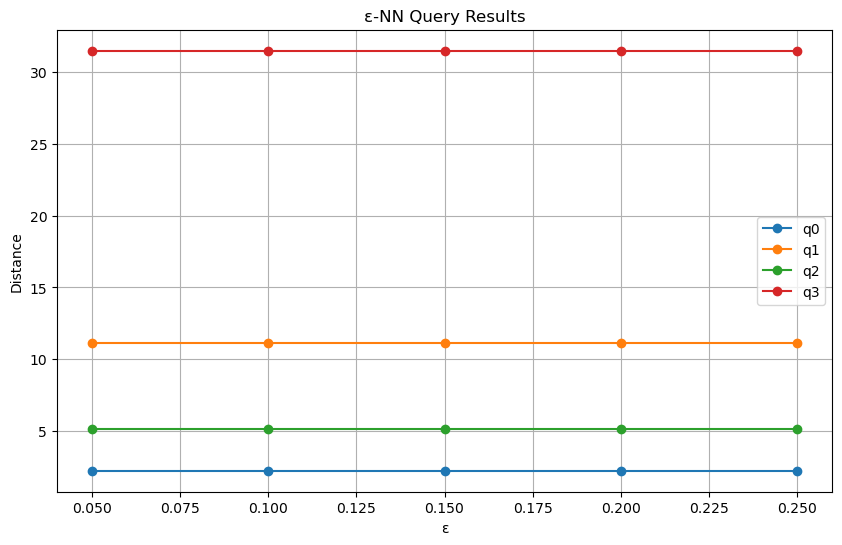

In [6]:
epsilons = [0.05, 0.1, 0.15, 0.2, 0.25]
results = {}

for query_name, query in queries.items():
    query_results = []
    print(f"\nResults for {query_name}:")
    for epsilon in epsilons:
        result, dist = tree.ann_search(query, epsilon)
        query_results.append((epsilon, dist))
        print(f"ε={epsilon:.2f}: dist={dist:.2f}, point={result}")
    results[query_name] = query_results

plt.figure(figsize=(10, 6))
for query_name, query_results in results.items():
    distances = [dist for _, dist in query_results]
    plt.plot(epsilons, distances, marker='o', label=f'{query_name}')

plt.xlabel('ε')
plt.ylabel('Distance')
plt.title('ε-NN Query Results')
plt.legend()
plt.grid(True)
plt.show()



In [7]:
num_queries = 1000
epsilon = 0.1
queries_1 = np.random.uniform(0, 1000, size=(num_queries, 2))

times_1 = []
dists_1 = []

for query in queries_1:
    start_time = time.time()
    _, dist = tree.ann_search(query, epsilon)
    times_1.append(time.time() - start_time)
    dists_1.append(dist)

print("\nResults for [0,1000]×[0,1000]:")
print(f"Average query time: {np.mean(times_1)*1000:.2f} ms")
print(f"Average dist: {np.mean(dists_1):.2f}")
print(f"Min/Max dist: {min(dists_1):.2f}/{max(dists_1):.2f}")




Results for [0,1000]×[0,1000]:
Average query time: 210.09 ms
Average dist: 3.90
Min/Max dist: 0.15/12.99


In [8]:
queries_2 = np.random.uniform(1000, 1500, size=(num_queries, 2))
times_2 = []
dists_2 = []

for query in queries_2:
    start_time = time.time()
    _, dist = tree.ann_search(query, epsilon)
    times_2.append(time.time() - start_time)
    dists_2.append(dist)

print("\nResults for [1000,1500]×[1000,1500]:")
print(f"Average query time: {np.mean(times_2)*1000:.2f} ms")
print(f"Average dist: {np.mean(dists_2):.2f}")
print(f"Min dist: {min(dists_2):.2f}")
print(f"Max dist: {max(dists_2):.2f}")

new_points_2 = np.random.uniform(1000, 2000, size=(2000, 2))
insert_times_2 = []

for point in new_points_2:
    start_time = time.time()
    tree.insert(point)
    insert_times_2.append(time.time() - start_time)

print(f"\nAverage insertion time for new points: {np.mean(insert_times_2)*1000:.2f} ms")




Results for [1000,1500]×[1000,1500]:
Average query time: 243.13 ms
Average dist: 398.45
Min dist: 17.48
Max dist: 711.39

Average insertion time for new points: 0.72 ms


In [9]:
queries_3 = np.random.uniform(1000, 2000, size=(num_queries, 2))
times_3 = []
dists_3 = []

for query in queries_3:
    start_time = time.time()
    _, dist = tree.ann_search(query, epsilon)
    times_3.append(time.time() - start_time)
    dists_3.append(dist)

print("\nResults for [1000,2000]×[1000,2000]:")
print(f"Average query time: {np.mean(times_3)*1000:.2f} ms")
print(f"Average dist: {np.mean(dists_3):.2f}")
print(f"Min dist: {min(dists_3):.2f}")
print(f"Max dist: {max(dists_3):.2f}")



Results for [1000,2000]×[1000,2000]:
Average query time: 448.22 ms
Average dist: 11.20
Min dist: 0.14
Max dist: 36.47
